<a href="https://colab.research.google.com/github/ozgesengil/fMRI_Analysis_Scripts/blob/main/BOLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling & Estimating the BOLD response
## Hemodynamic Impulse Response Function
Hemodynamice impulse response function (HIRF or sometimes just HRF) is a hypothetical function that represents the BOLD response following a single brief neuronal activity. This function emerges as the link between the neuronal activity and BOLD response as we discussed in the class. In principle it can be estimated by recording the BOLD response associated with a brief neuronal activity. For example, one can present a very brief (e.g. a few hundred ms) visual stimulus and record responses in the primary visual cortex. But this approach had limited success because of several reasons. Firstly, it is suitable only for sensory and motor systems. For higher cognitive processes, such as memory or emotion, it is harder to elicit a "brief pulse" of neuronal activity. Secondly, owing to the large non-linearities in the BOLD response at short durations of neuronal activity, it is not possible to obtain an HRF that would be valid for longer durations of neuronal activity with this technique. One of the alternatives is using a mathematical function.
## HIRF: Mathematical Formulations
Researchers adapted mathematical functions whose shape closely resemble the empirical HIRF observed in many real experiments.
### Gamma Distribution
One of the very first functions adapted was single gamma probability distribution function (Boynton, Engel, Glover, Heeger, 'Linear Systems Analysis of Functional Magnetic Resonance Imaging in Human V1', 1996):
$$h(t) = \frac{1}{(n-1)!} \frac{(t-t_0)^{n-1}\exp(-(t-t_0)/\lambda)}{\lambda^{n}}. $$
To see how the shape depends on the parameters $\lambda$, $n$ and $t_0$ run the cells below and play with the sliders.

In [ ]:
# Press the play button to run the cell
from scipy.stats import gamma
from scipy.special import factorial
import matplotlib.pyplot as plt
import numpy as np

def hrf_single_gamma(t,n,lmbd,t0):
  return gamma.pdf(t,n,loc=t0,scale=lmbd)

A sample plot:

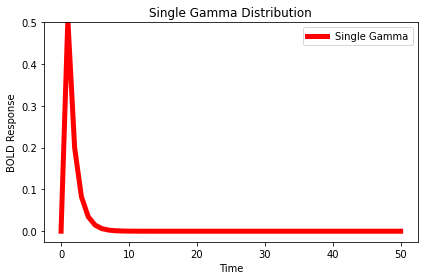

In [ ]:
# @title Try playing with sliders and re-running the cell
# time range
time = np.arange(0, 51, 1.0)

# parameters for single and double gamma distribution functions
n = 0.9 #@param {type:"slider", min:0, max:10, step:0.1}
lmbd = 1.2 #@param {type:"slider", min:1, max:10, step:0.1}
t0 = 0.4 #@param {type:"slider", min:0, max:5, step:0.1}

bold_single_gamma = hrf_single_gamma(time, n, lmbd, t0)
plt.plot(time, bold_single_gamma, color = 'red',
         linewidth = 5, label="Single Gamma")
plt.ylim(top=0.5)
plt.xlabel('Time')
plt.ylabel('BOLD Response')
plt.title('Single Gamma Distribution')
plt.legend()
plt.tight_layout()
plt.show()

###Double Gamma Distribution:
The single gamma distribution function has no undershoot part, thus it is not consistent with the observed BOLD responses. A difference of two gamma distribution functions solves this problem:
$$h(t) = \frac{1}{C} {\Large[} \frac{1}{(n_1-1)!}
        \frac{(t-t0_1)^{n_1-1}\exp(-(t-t0_1)/\lambda_1)}{\lambda_1^{n1}}
         - a \frac{1}{(n_2-1)!}
        \frac{(t-t0_2)^{n_2-1}\exp(-(t-t0_2)/\lambda_2)}{\lambda_2^{n_2}}
        {\Large]}$$
        
 where $C$ is a normalization constant, and  $0<a<1$

In [ ]:
def hrf_double_gamma(t,n1,n2,lmbd1,lmbd2,t01,t02,a):
  c = (gamma.cdf(t[t.size-1],n1,loc=t01,scale=lmbd1)
        - a * gamma.cdf(t[t.size-1],n2,loc=t02,scale=lmbd2))
  return ( 1/c * (gamma.pdf(t,n1,scale=lmbd1,loc=t01)
                   - a * gamma.pdf(t,n2,scale=lmbd2,loc=t02)))

A sample plot:

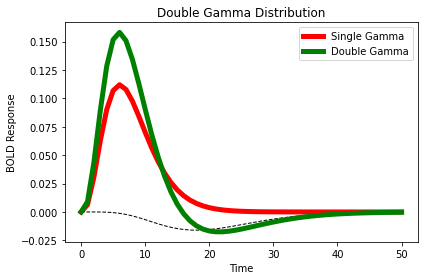

In [ ]:
time = np.arange(0, 51, 1.0)
# parameters for single and double gamma distribution functions
n1 = 4 #@param {type:"slider", min:0, max:10, step:0.1}
lmbd1 = 2 #@param {type:"slider", min:1, max:10, step:0.1}
t01 = 0 #@param {type:"slider", min:0, max:10, step:0.1}
n2 = 7 #@param {type:"slider", min:0, max:10, step:0.1}
lmbd2 = 3 #@param {type:"slider", min:1, max:10, step:0.1}
t02 = 0 #@param {type:"slider", min:0, max:10, step:0.1}
a = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}
# First plot a single gamma distribution
plt.plot(time, hrf_single_gamma(time, n1, lmbd1, t01), color = 'red',
         linewidth = 5, label="Single Gamma")
plt.xlabel('Time')
plt.ylabel('BOLD Response')
plt.title('Double Gamma Distribution')
plt.legend()
# Next negative of a second gamma distribution
plt.plot(time, - a * hrf_single_gamma(time, n2, lmbd2, t02),
         color = 'black', linewidth = 1, linestyle='dashed')
# Plot the normalized sum of two gamma dist. functions
bold_double_gamma = hrf_double_gamma(time, n1, n2, lmbd1, lmbd2, t01, t02, a)
plt.plot(time, bold_double_gamma,
         color = 'green', linewidth = 5, label="Double Gamma")
plt.legend()
plt.tight_layout()
plt.show()


###Friston's Linear HRF
Friston et al. (1998) has introduced the following form of HRF

$$h(t) = \beta_1\, b_1(t) + \beta_2\, b_2(t) + \beta_3\, b_3(t)$$

where

$$b_1(t) = \frac{1}{3!} t^3 \exp(-t), \\
        b_2(t) = \frac{1}{7!} t^7 \exp(-t),\\
        b_3(t) = \frac{1}{15!} t^{15} \exp(-t)$$.
    
This is a useful form, because as we will see below, it allows for computationally more efficient estimation of parameters in the HRF.

In [ ]:
def hrf_friston(t, beta1, beta2, beta3):
  return (beta1 * 1.0/factorial(3) * np.power(t,3) * np.exp(-t)
    + beta2 * 1.0/factorial(7) * np.power(t,7) * np.exp(-t)
    + beta3 * 1.0/factorial(15) * np.power(t,15) * np.exp(-t) )

A sample:

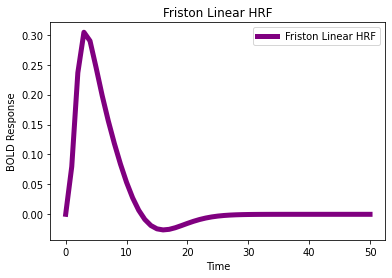

In [ ]:
beta1 = 1.3 #@param{type:"slider", min:-10, max:10, step:0.1}
beta2 = 0.6 #@param{type:"slider", min:-10, max:10, step:0.1}
beta3 = -0.3 #@param{type:"slider", min:-10, max:10, step:0.1}

bold_friston_linear = hrf_friston(time, beta1, beta2, beta3)
plt.plot(time, bold_friston_linear, color = 'purple',
         linewidth = 5, label="Friston Linear HRF")
plt.xlabel('Time')
plt.ylabel('BOLD Response')
plt.title('Friston Linear HRF')
plt.legend()
plt.show()

Plotting all three together:

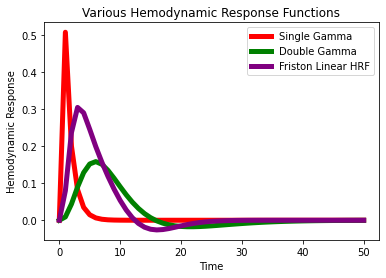

In [ ]:
plt.plot(time, bold_single_gamma, color = 'red',
         linewidth = 5, label="Single Gamma")
plt.plot(time, bold_double_gamma,
         color = 'green', linewidth = 5, label="Double Gamma")
plt.plot(time, bold_friston_linear, color = 'purple',
         linewidth = 5, label="Friston Linear HRF")
plt.xlabel('Time')
plt.ylabel('Hemodynamic Response')
plt.title('Various Hemodynamic Response Functions')
plt.legend()
plt.show()


##Convolution with Neuronal Response

BOLD response can be formulized as the convolution of the neuronal response and the hemodynamic impulse response function:

$$ B(t) \stackrel{\text{def}}{=} [N*h](t) = \int_0^t N(\tau) \, h(t-\tau) \, d\tau$$

Of course the data acquired are noisy: There are various sources of noise, some neuronal some hemodynamic. Try simulating BOLD response with or without noise using the code below

In [ ]:
from scipy.stats import norm

def bold_response(n, h):
  return np.convolve(n,h)

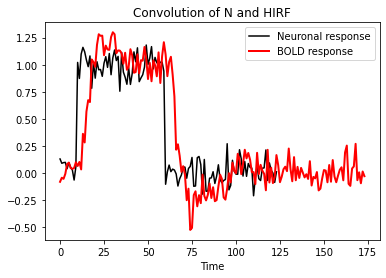

In [ ]:
time = np.arange(0,124,1.0)
onset=10
duration=50 #@param{type:"integer"}
# neural response with and without noise:
boxNoNoise=np.concatenate((np.zeros(onset), np.ones(duration), \
                    np.zeros(time.size-duration-onset)))
neuronal_noise = True #@param {type:"boolean"}
if(neuronal_noise):
  neuronal_noise_level = 0.1 #@param {type:"raw"}
  box = boxNoNoise + norm.rvs(scale=neuronal_noise_level, size=boxNoNoise.size)
else:
  box = boxNoNoise
plt.plot(time, box, color = 'black', label = 'Neuronal response')

HRF = 'Double-Gamma' #@param ["Single-Gamma", "Double-Gamma", "Friston Linear"]
if HRF=="Single-Gamma":
  h = bold_single_gamma
elif HRF=="Double-Gamma":
  h = bold_double_gamma
else:
  h = bold_friston_linear

bold = bold_response(box,h)
hemodynamic_noise = True #@param {type:"boolean"}
hemodynamic_noise_level = 0.1 #@param {type:"raw"}
if(hemodynamic_noise):
  bold += norm.rvs(scale=hemodynamic_noise_level, size=bold.size)
t = np.arange(0,bold.size,1)
plt.plot(t, bold, color = 'red', linewidth=2, label = "BOLD response")

plt.title('Convolution of N and HIRF')
plt.xlabel('Time')
plt.legend()
plt.show()

##Convolution Theorem
If $B(t) = (N * h)(t)$ then according to convolution theorem

\begin{eqnarray*}
\mathcal{F}\left[B(t)\right] &=& \mathcal{F} \left[ (N*h)(t) \right]
                               = \mathcal{F} \left[ N(t) \right] \mathcal{F} \left[ h(t) \right],
\end{eqnarray*}

where $\mathcal{F}$ stands for Fourier transform. From which it follows that

\begin{equation*}
h(t) = \mathcal{F}^{-1} \left[ \frac{\mathcal{F}\left[ B(t) \right]}{\mathcal{F} \left[ N(t) \right]} \right].
\end{equation*}

One can in principle use the above equation to estimate the HIRF given the BOLD response and neuronal response. Let's try if that works. First, compute HIRF using BOLD and neuronal responses.

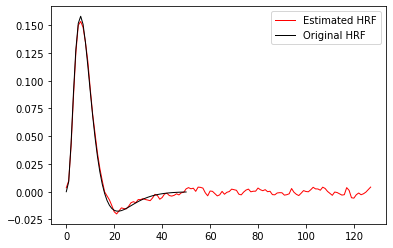

In [ ]:
# @title Use deconvolution to find HIRF assuming the neural response
import numpy.fft as fft

#Replace box with boxNoNoise below for a no-noise Neuronal boxcar response

fbox = fft.rfft(box)
fbold = fft.rfft(bold[0:box.size])
hrf_estimate = fft.irfft(np.divide(fbold,fbox),128)

t = np.arange(0, hrf_estimate.size, 1)
plt.plot(t, hrf_estimate, color='red', linestyle='solid', linewidth=1,
         label = "Estimated HRF")
plt.plot(h, color='black', linestyle='solid', linewidth=1,
         label = "Original HRF")
plt.legend()
plt.show()


Next, compute the neuronal response assuming the HIRF. Will that work?

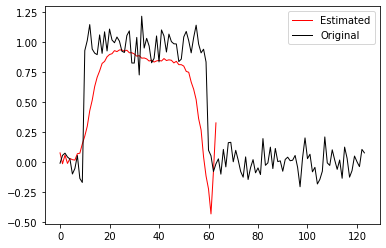

In [ ]:
# @title Use deconvolution to find neural response assuming the HIRF

fbold = fft.rfft(bold[0:h.size]) # Fourier transform of BOLD response

# Arash suggested removing high-frequency components for the noisy-bold condition:
arash_trick = False #@param {type:"boolean"}
if arash_trick:
  fbold [ abs ( fbold ) < 3] = 0 # This line added

fh = fft.rfft(h) # Fourier transform of the HRF

# new trick using Wiener filter:
Wiener_Filter = True #@param {type:"boolean"}
if Wiener_Filter:
  sigma = 100
  fh = fh * (abs(fh)+sigma)/(abs(fh))
else:
  sigma = 1

box_estimate = fft.irfft(np.divide(fbold,fh),64) * sigma

t = np.arange(0, box_estimate.size, 1)
plt.plot(t, box_estimate, color='red', linestyle='solid', linewidth=1,
         label = 'Estimated')
plt.plot(box, color='black', linestyle='solid', linewidth=1,
         label = 'Original')
plt.legend()
plt.show()

##Friston's Non-linear HIRF
All of the HIRFs above can be used to calculate the predicted BOLD reponse assuming that the BOLD response is linear. But as we discussed in class, BOLD response may not always be linear, especially for extremely small durations and when trials are separated with short ISIs. Friston et al. (1998) proposed using Volterra series up to 2nd order to incorporate possible non-linearities in BOLD response:
$$B(t) = \sum_{i=1}^{3} \beta_i\,x_i(t)
        + \sum_{i=1}^{3} \sum_{j=1}^{3} \beta_{ij}\,x_i(t)x_j(t)$$
        
where

$$ x_i(t) = (N \star b_i)(t)$$

N is the neuronal response, and
    
$$   b_1(t) = \frac{1}{3!} t^3 \exp(-t)\\
        b_2(t) = \frac{1}{7!} t^7 \exp(-t)\\
        b_3(t) = \frac{1}{15!} t^{15} \exp(-t)$$

Here is the definition of the non-linear HIRF:

In [ ]:
#@title Friston Non-linear HIRF
def bold_response_nonlinear(n,
                            beta1, beta2, beta3,
                            beta11, beta12, beta13,
                            beta21, beta22, beta23,
                            beta31, beta32, beta33):

    t = np.arange(0,n.size,1.0)
    b1 = 1.0/factorial(3) * np.power(t,3) * np.exp(-t)
    b2 = 1.0/factorial(7) * np.power(t,7) * np.exp(-t)
    b3 = 1.0/factorial(15) * np.power(t,15) * np.exp(-t)

    x1 = np.convolve(n,b1)
    x2 = np.convolve(n,b2)
    x3 = np.convolve(n,b3)

    y11 = np.multiply(x1, x1)
    y12 = np.multiply(x1, x2)
    y13 = np.multiply(x1, x3)
    y21 = np.multiply(x2, x1)
    y22 = np.multiply(x2, x2)
    y23 = np.multiply(x3, x3)
    y31 = np.multiply(x3, x1)
    y32 = np.multiply(x3, x2)
    y33 = np.multiply(x3, x3)

    return (beta1*x1 + beta2*x2 + beta3*x3
           + beta11*y11 + beta12*y12 + beta13*y13
           + beta21*y21 + beta22*y22 + beta23*y23
           + beta31*y31 + beta32*y32 + beta33*y33)

And here is a sample implementation:

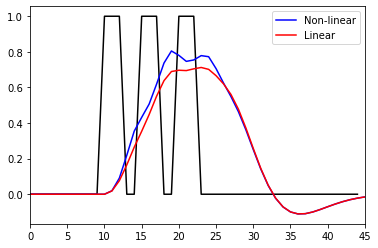

In [ ]:
#@title Sample non-linear response to a series of neuronal activities
# the following demonstrates the Friston non-linear hrf:
onset=10
block_duration = 3 #@param {type:"slider", min:1, max:10, step:1}
inter_block_interval=2 #@param{type:"slider", min:1, max:30, step:1}
box=np.concatenate((np.zeros(onset),
                    np.ones(block_duration),np.zeros(inter_block_interval),
                    np.ones(block_duration),np.zeros(inter_block_interval),
                    np.ones(block_duration),np.zeros(inter_block_interval),
                    np.zeros(20)))
time = np.arange(0,box.size,1.0)
plt.plot(time, box, color = 'black')

beta1 = 0.3
beta2 = 1
beta3 = -0.3

beta11 = 0.25
beta12 = 0
beta13 = -0.25
beta21 = 0
beta22 = 0
beta23 = 0
beta31 = 0
beta32 = 0
beta33 = 0
bold = bold_response_nonlinear(box,
                               beta1, beta2, beta3,
                               beta11, beta12, beta13,
                               beta21, beta22, beta23,
                               beta31, beta32, beta33)
# uncomment the following line to add noise
#bold += norm.rvs(scale=0.2, size=bold.size)
t = np.arange(0, bold.size, 1)
plt.plot(t, bold, color = 'blue', label = "Non-linear")


h = hrf_friston(time, beta1, beta2, beta3)
bold = bold_response(box,h)
plt.plot(t, bold, color = 'red', label = "Linear")

plt.xlim(0,box.size)
plt.legend()
plt.show()

##Simulated BOLD Response Time-course

Now we are ready to simulate the BOLD response to neuronal activity in a hypothetical block-design paradigm. Let's approximate the neuronal activity as boxcars:  

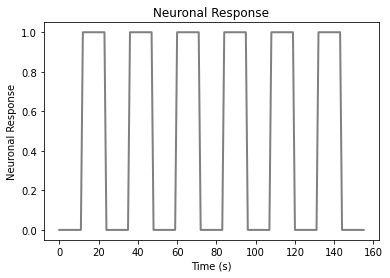

In [ ]:
#@title A boxcar neuronal response

onset = 12 #@param {type:"integer"}
active_duration = 12 #@param {type:"integer"}
rest_duration = 12 #@param {type:"integer"}
block_duration = active_duration+rest_duration
number_of_blocks = 6 #@param {type:"integer"}
box = np.zeros(onset + block_duration*number_of_blocks)
block_start = np.arange(onset, number_of_blocks*block_duration, block_duration)
for start in block_start:
  box[start:start+active_duration] = np.ones(active_duration)
neuronal_noise = False #@param {type:"boolean"}
if(neuronal_noise):
  neuronal_noise_level = 0.1 #@param {type:"raw"}
  box += norm.rvs(scale=neuronal_noise_level, size=box.size)
plt.plot(box, color='gray', linestyle='solid', linewidth=2)
plt.title("Neuronal Response")
plt.xlabel("Time (s)")
plt.ylabel("Neuronal Response")
plt.show()

Next, using one of the mathematical forms of HIRF let's simulate BOLD response:

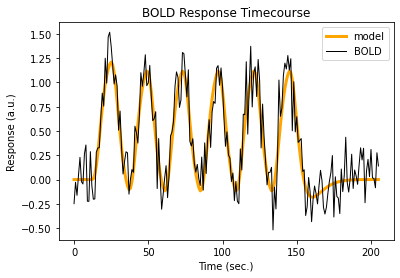

In [ ]:
#@title Simulated BOLD response
HRF = 'Double-Gamma' #@param ['Single-Gamma','Double-Gamma','Friston Linear','Friston Non-Linear']
if HRF=="Single-Gamma":
  h = bold_single_gamma
elif HRF=="Double-Gamma":
  h = bold_double_gamma
elif HRF == "Friston Linear":
  h = bold_friston_linear

# convolve h and n to compute the bold response
if HRF == "Friston Non-Linear":
  bold = bold_response_nonlinear(box,
                               beta1, beta2, beta3,
                               beta11, beta12, beta13,
                               beta21, beta22, beta23,
                               beta31, beta32, beta33)
else:
  bold = bold_response(box, h)

model = np.array(np.arange(0,bold.size),dtype=float)
model[0:bold.size] = bold[0:bold.size] # model with no noise
bold_noise = True #@param {type:"boolean"}
if(bold_noise):
  bold_noise_level =  0.2#@param {type:"raw"}
  bold += norm.rvs(scale=bold_noise_level, size=bold.size)

t = np.arange(0, box.size+50, 1)
plt.plot(t, model[0:t.size], color='orange', linestyle='solid', linewidth=3,
         label='model')
plt.plot(t, bold[0:t.size], color='black', linestyle='solid', linewidth=1,
         label='BOLD')
plt.title('BOLD Response Timecourse')
plt.xlabel('Time (sec.)')
plt.ylabel('Response (a.u.)')
plt.legend()
plt.show()

##Fitting a Model to the BOLD Response

Can we recover the underlying model if we are given the above BOLD response (after noise added)? Let's try to find out. Let's minimize an error function - sum of squared errors (SSE) - between our model and the simulated BOLD response, and thus obtain the best fitting model to the simulated data:

In [ ]:
#@title Methods definitions for the Optimization Code
from scipy.optimize import leastsq

def bold_predicted_single_gamma(x, box):

    n1 = x[0]
    lmbd1 = x[1]
    t01 = x[2]
    time = np.arange(0, 51, 1)
    hrf = hrf_single_gamma(time, n1, lmbd1, t01)
    return np.convolve(box, hrf)

def bold_predicted_double_gamma(x, box):

    n1 = x[0]
    n2 = x[1]
    lmbd1 = x[2]
    lmbd2 = x[3]
    t01 = x[4]
    t02 = x[5]
    a = x[6]

    time = np.arange(0, 51, 1)
    hrf = hrf_double_gamma(time, n1, n2, lmbd1, lmbd2, t01, t02, a)
    return np.convolve(box, hrf)

def bold_predicted_friston(x, box):

    beta1 = x[0]
    beta2 = x[1]
    beta3 = x[2]
    time = np.arange(0, 51, 1)
    hrf = hrf_friston(time, beta1, beta2, beta3)
    return np.convolve(box, hrf)

def diff_friston(x, bold_o, box):
    """Calculates the difference between predicted and observed BOLD"""

    bold_p = bold_predicted_friston(x, box)
    diff = (bold_p - bold_o[0:bold_p.size])
    return diff

def diff_single_gamma(x, bold_o, box):
    """Calculates the difference between predicted and observed BOLD"""

    bold_p = bold_predicted_single_gamma(x, box)
    diff = (bold_p - bold_o[0:bold_p.size])
    return diff

def diff_double_gamma(x, bold_o, box):
    """Calculates the difference between predicted and observed BOLD"""

    bold_p = bold_predicted_double_gamma(x, box)
    diff = (bold_p - bold_o[0:bold_p.size])
    return diff

(array([ 2.88537089e+00,  1.27443865e+03,  2.43879693e+00,  4.03657253e-01,
        8.38126651e-01, -4.94957645e+02,  3.81618701e-01]), 5)


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1600.
  warnings.warn(errors[info][0], RuntimeWarning)


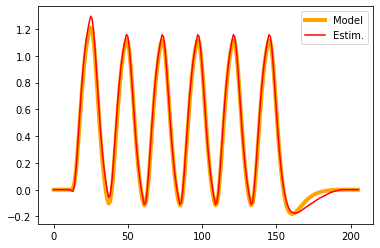

In [ ]:
plt.plot(t, model[0:t.size], color = 'orange', label='Model',linewidth=4)
#plt.plot(t, bold[0:t.size], color='black', label='BOLD', linewidth=2)

HRF = 'Double-Gamma' #@param ['Single-Gamma','Double-Gamma','Friston Linear']
if HRF=="Single-Gamma":
  x0 = np.array([n, lmbd, t0])
  res = leastsq(diff_single_gamma, x0, args =(bold, box), full_output=0)
  t = np.arange(0, box.size+50, 1)
  plt.plot(t, bold_predicted_single_gamma(res[0], box)[0:t.size],
           color='red', label='Estim.')
elif HRF=="Double-Gamma":
  x0 = np.array([n1, n2, lmbd1, lmbd2, t01, t02, a])
  res = leastsq(diff_double_gamma, x0, args =(bold, box), full_output=0)
  plt.plot(t, bold_predicted_double_gamma(res[0], box)[0:t.size], color='red',
        label='Estim.')
elif HRF=="Friston Linear":
  x0 = np.array([beta1,beta2,beta3])
  res = leastsq(diff_friston, x0, args =(bold, box), full_output=0)
  plt.plot(t, bold_predicted_friston(res[0], box)[0:t.size], color='red',
        label='Estim.')
print(res)
plt.legend()
plt.show()

##Event-related Average
One can also take event-related average of multiple trials (i.e. active blocks)

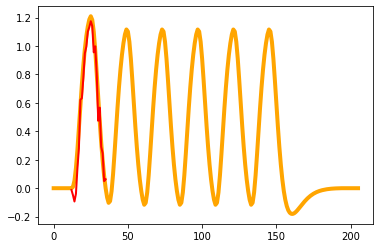

In [ ]:
epoch_start = 0
epoch_end = active_duration + rest_duration
index = np.empty([0])
for i in block_start:
  index = np.append(index,np.array([np.arange(i+epoch_start,i + epoch_end,1)]))
index = index.reshape(number_of_blocks, epoch_end - epoch_start)
index = index.astype(int)
era = np.mean(bold[index], axis = 0, dtype = np.float64)
#t_ER = np.arange(onset, onset+block_duration,1)
t_ER = np.arange(onset + epoch_start, onset + epoch_end,1)
plt.plot(t, model[t], color = 'orange', label='Model',linewidth=4)
plt.plot(t_ER, era, color = 'red', linewidth = 2)
#plt.plot(t, bold[t], color='black', label='BOLD', linewidth=1)
plt.show()

##Things to do


1. FIR fit
2. Fix the deconvolutions - DONE
3. Friston non-linear fit
4. Compare different model fits with BIC or AIC
5. Optimize minimization for Friston linear
6. Derivative time shift model
7. Jittered ITI
8. Exercises
       





